ガウス混合モデル
==============

ガウス混合モデル（Gaussian Mixture Model, GMM）は、
データがいくつかの異なる正規分布（ガウス分布）の組み合わせから生成されていると仮定する確率モデルです。
この章では、GMMの概念、数学的な定式化、そしてクラスタリング問題への応用について説明します。

## 基本的な考え方

まずはGMMの動機となる例を見てみましょう。以下のようなデータを考えます。

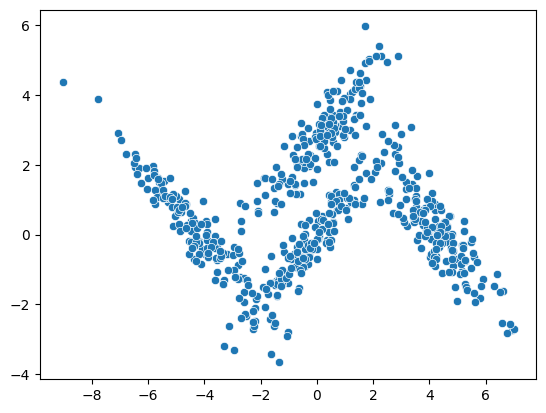

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns

n_samples = 600
centers = [[-3, -3], [0, 0], [3, 3], [-2, 2]]
cluster_std = [[2, 0.3], [0.3, 2], [1.5, 0.4], [0.4, 1.5]]

X, _ = make_blobs(n_samples=n_samples,
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=42)

theta = np.pi / 4
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])
X = np.dot(X, rotation_matrix)

sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.show()

このデータは明らかに複数のクラスタに分かれていて、各クラスタは楕円形の形状をしています。
このようなデータに対して、まずは{ref}`k-means<k-means>`法でクラスタリングを試みてみましょう。

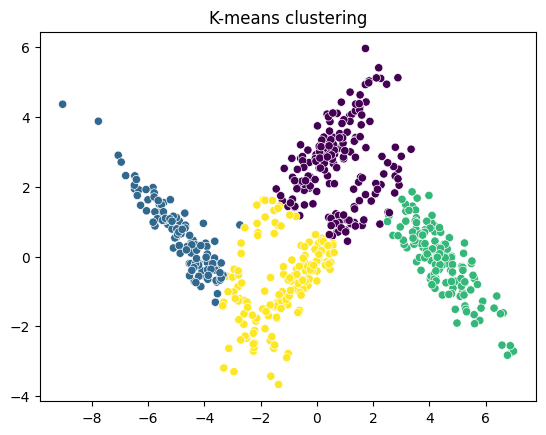

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Xに図中の座標データ

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means clustering')
plt.show()

k-means法では思ったようにクラスタリングできていないことがわかります。
これは、k-means法の持つ以下の特性によるものです。

- クラスタ内の分散を最小化するため、球形のクラスタを仮定する
- 各データポイントは距離が最も近いクラスタに割り当てられる
- 各クラスタは単一の中心点で表現される

しかし、実際のデータはしばしば楕円形の分布を持ち、クラスタの形状や大きさが異なることがあります。
このような場合にGMMが効果的です。

## ガウス混合モデルによるクラスタリング

同じデータをGMMでクラスタリングしてみましょう。

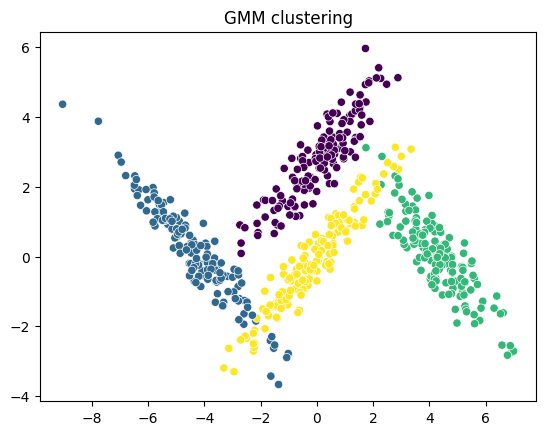

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM clustering')
plt.show()

GMMでは正しくクラスタリングできています。
なぜGMMがこのような状況で優れているのでしょうか？

GMMは以下の特長を持っています。

- 各クラスタを多変量正規分布で表現できるため、楕円形の形状を捉えられる
- 確率的なモデルであり、各データポイントが各クラスタに属する確率を計算できる
- クラスタの大きさや形状が異なる場合でも対応できる
- データ生成過程をモデル化するため、新しいデータの生成やクラスタごとの特性の理解が可能

## ガウス混合モデルの数学的表現

GMMは、K個の正規分布の重み付き和として以下のように表現されます。

$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)$

ここで：
- $\pi_k$は各成分（クラスタ）の混合重み（$\sum_{k=1}^K \pi_k = 1$）
- $\mu_k$は各成分の平均ベクトル
- $\Sigma_k$は各成分の共分散行列
- $\mathcal{N}(x|\mu_k, \Sigma_k)$は多変量正規分布

多変量正規分布は以下の確率密度関数で表されます。

$$\mathcal{N}(x|\mu_k, \Sigma_k) = \frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}} \exp\left(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)\right)$$

ここで $d$ はデータの次元数、$|\Sigma_k|$ は共分散行列の行列式です。

## EMアルゴリズム

GMMのパラメータ推定には、Expectation-Maximization（EM）アルゴリズムが使用されます。
これは、直接最適化が難しい問題を、繰り返し計算で解く手法です。

```{prf:algorithm} GMMのEMアルゴリズム
:label: gmm-algo

1. パラメータ$\pi_k$, $\mu_k$, $\Sigma_k$を初期化
2. 以下を収束するまで繰り返す
   1. E-step: 各データポイントの各クラスタへの所属確率を計算
      $\gamma_{ik} = \frac{\pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_i|\mu_j, \Sigma_j)}$
   2. M-step: パラメータを更新
      - $\pi_k^{new} = \frac{1}{N}\sum_{i=1}^N \gamma_{ik}$
      - $\mu_k^{new} = \frac{\sum_{i=1}^N \gamma_{ik}x_i}{\sum_{i=1}^N \gamma_{ik}}$
      - $\Sigma_k^{new} = \frac{\sum_{i=1}^N \gamma_{ik}(x_i-\mu_k^{new})(x_i-\mu_k^{new})^T}{\sum_{i=1}^N \gamma_{ik}}$
```

このアルゴリズムは、対数尤度を単調に増加させながら収束していきます。

## GMMの適用例

偏差値は成績が正規分布に従うという仮定を元に計算されています。
しかし、その過程を満たさない分布もあります。
以下のような2峰性の分布を持つ成績を考えてみましょう。

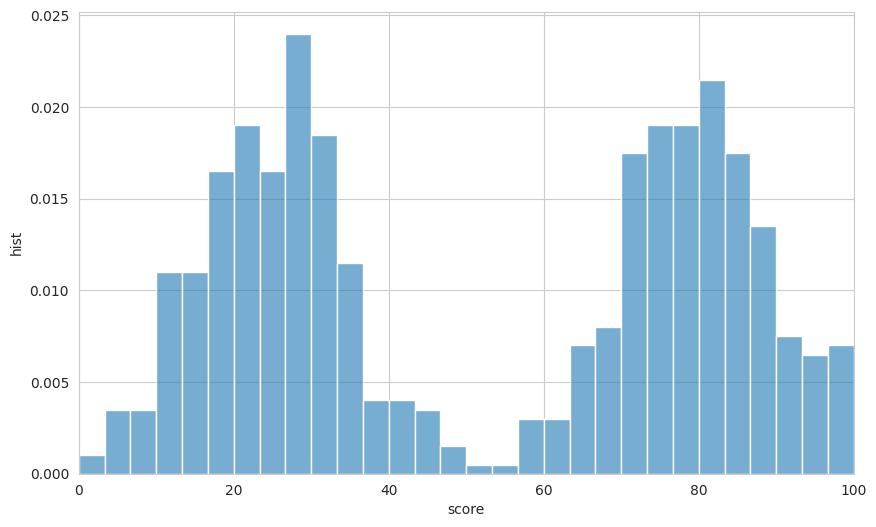

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
a = np.random.normal(25, 10, 300)
b = np.random.normal(80, 10, 300)

total = np.clip(np.concatenate([a, b]), 0, 100)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.histplot(data=total, bins=30, stat="density", alpha=0.6)
plt.xlabel('score')
plt.ylabel('hist')
plt.xlim(0, 100)
plt.show()

このような成績の分布は、例えば「基礎的な内容が理解できている学生」と「発展的な内容まで理解できている学生」が混在しているクラスで見られるかもしれません。このデータにGMMを適用してみましょう

成分1: 平均 = 24.79, 標準偏差 = 9.44, 重み = 0.50
成分2: 平均 = 79.59, 標準偏差 = 9.59, 重み = 0.50


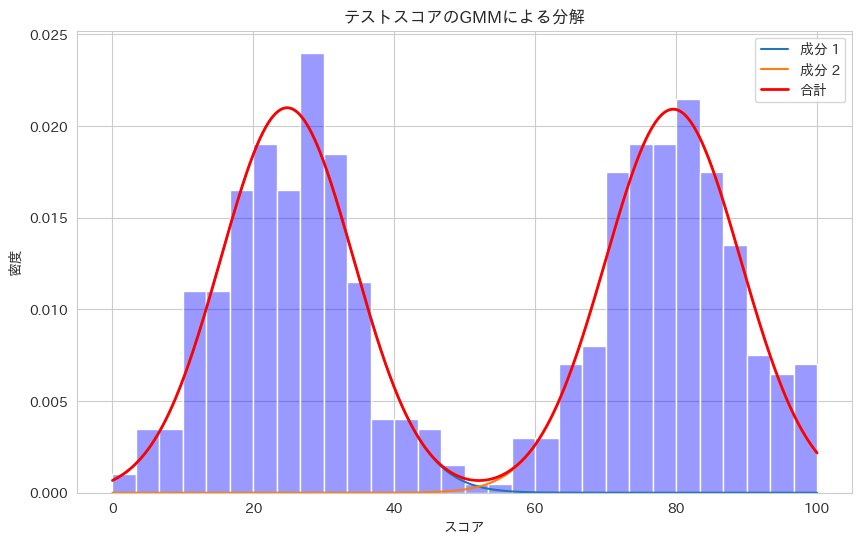

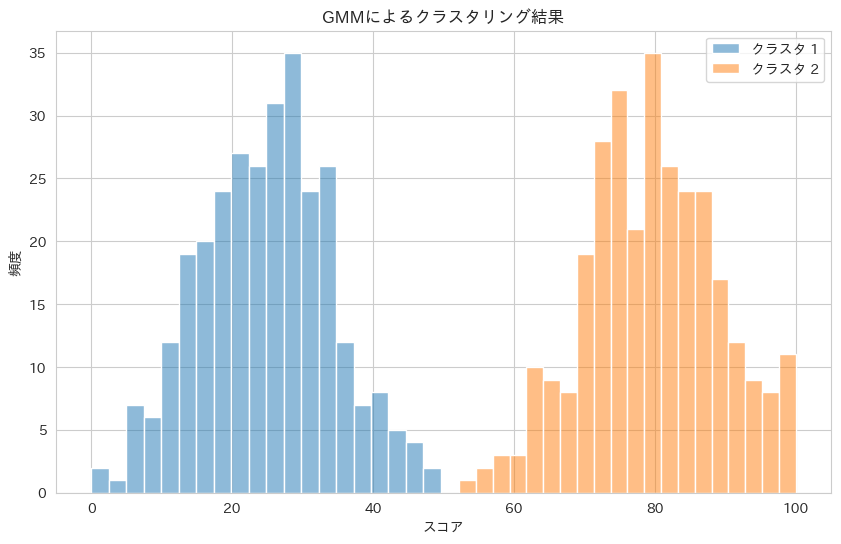

In [5]:
import scipy
import japanize_matplotlib

# GMMを適用（2つの成分を使用）
X_1d = total.reshape(-1, 1)  # GMMに入力するために2D配列に変換
gmm_1d = GaussianMixture(n_components=2, random_state=42)
gmm_1d.fit(X_1d)

# 各成分の平均と標準偏差を表示
means = gmm_1d.means_.flatten()
stds = np.sqrt(gmm_1d.covariances_.flatten())
weights = gmm_1d.weights_

print(f"成分1: 平均 = {means[0]:.2f}, 標準偏差 = {stds[0]:.2f}, 重み = {weights[0]:.2f}")
print(f"成分2: 平均 = {means[1]:.2f}, 標準偏差 = {stds[1]:.2f}, 重み = {weights[1]:.2f}")

# 元のデータと、GMM成分のプロット
plt.figure(figsize=(10, 6))
sns.histplot(data=total, bins=30, stat="density", alpha=0.4, color='blue')

# 各ガウス成分を描画
x = np.linspace(0, 100, 1000)
for i in range(2):
    plt.plot(x, weights[i] * 
             scipy.stats.norm.pdf(x, means[i], stds[i]), 
             label=f'成分 {i+1}')

# 全体の分布を描画
plt.plot(x, np.sum([weights[i] * 
                   scipy.stats.norm.pdf(x, means[i], stds[i]) 
                   for i in range(2)], axis=0),
         'r-', label='合計', linewidth=2)

plt.xlabel('スコア')
plt.ylabel('密度')
plt.title('テストスコアのGMMによる分解')
plt.legend()
plt.show()

# データポイントのクラスタ割り当て
clusters = gmm_1d.predict(X_1d)

# クラスタごとのヒストグラム
plt.figure(figsize=(10, 6))
for i in range(2):
    sns.histplot(total[clusters == i], bins=20, alpha=0.5, 
                 label=f'クラスタ {i+1}')
plt.xlabel('スコア')
plt.ylabel('頻度')
plt.title('GMMによるクラスタリング結果')
plt.legend()
plt.show()

この例では、2つの異なる成分に分けることで、データの背後にある2つの分布を特定できました。

## クラスタの形状確認

では、最初のデータセットを使用して、クラスタの形状や重なり具合を視覚的に見てみましょう。
このプロットでは、データポイントの色分けに加えて、各ガウス分布の確率密度を等高線で表示しています。

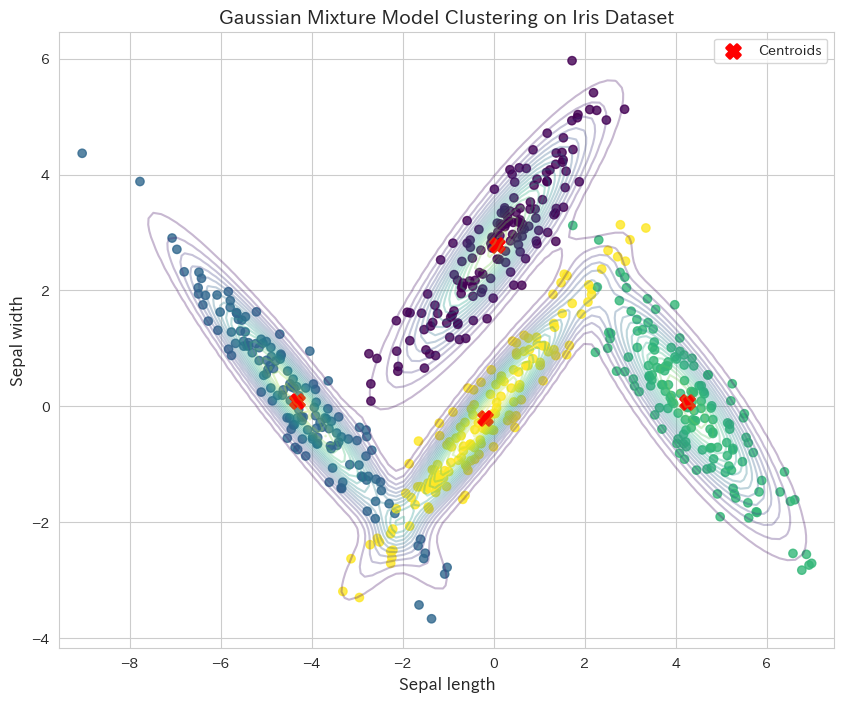

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# GMMモデルの作成と学習
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

# クラスタの予測
labels = gmm.predict(X)

# 等高線用のグリッド点を生成
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
XY = np.column_stack([xx.ravel(), yy.ravel()])

# 確率密度を計算
Z = gmm.score_samples(XY)
Z = Z.reshape(xx.shape)

# プロット
plt.figure(figsize=(10, 8))

# 確率密度の等高線をプロット
plt.contour(xx, yy, np.exp(Z), levels=20, cmap='viridis', alpha=0.3)

# データポイントをプロット
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8)

# 各ガウス分布の平均をプロット
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100, 
            linewidth=2, label='Centroids')

plt.xlabel('Sepal length', fontsize=12)
plt.ylabel('Sepal width', fontsize=12)
plt.title('Gaussian Mixture Model Clustering on Iris Dataset', fontsize=14)
plt.legend()
plt.show()